In [3]:
%matplotlib notebook
import os
import matplotlib.pyplot as plt
import numpy as np
import lal
import lalsimulation as lalsim
import sys
sys.path.append('../scripts')
import compute_sigmalm0_SimIMREOBGenerateQNMFreqV2 as calcqnm
import scipy
import scipy.signal as ss
from scipy import interpolate
import scipy.ndimage.filters as filter
from optparse import OptionParser
import corner

In [4]:
# Module for confidence calculations
class confidence(object):
    def __init__(self, counts):
        # Sort in descending order in frequency
        self.counts_sorted = np.sort(counts.flatten())[::-1]
        # Get a normalized cumulative distribution from the mode
        self.norm_cumsum_counts_sorted = np.cumsum(self.counts_sorted) / np.sum(counts)
        # Set interpolations between heights, bins and levels
        self._set_interp()
    def _set_interp(self):
        self._length = len(self.counts_sorted)
        # height from index
        self._height_from_idx = interpolate.interp1d(np.arange(self._length), self.counts_sorted, bounds_error=False, fill_value=0.)
        # index from height
        self._idx_from_height = interpolate.interp1d(self.counts_sorted[::-1], np.arange(self._length)[::-1], bounds_error=False, fill_value=self._length)
        # level from index
        self._level_from_idx = interpolate.interp1d(np.arange(self._length), self.norm_cumsum_counts_sorted, bounds_error=False, fill_value=1.)
        # index from level
        self._idx_from_level = interpolate.interp1d(self.norm_cumsum_counts_sorted, np.arange(self._length), bounds_error=False, fill_value=self._length)
    def level_from_height(self, height):
        return self._level_from_idx(self._idx_from_height(height))
    def height_from_level(self, level):
        return self._height_from_idx(self._idx_from_level(level))

# gaussian filter of histogram
def gf(P):
    return filter.gaussian_filter(P, sigma=1.0)

# GW150914

## Real data

In [5]:
data_gr = '/home/abhirup.ghosh/Documents/Work/spinqnm/runs/XLALSimInspiralChooseTDWaveformFromCache_runs_backup/ligo_events/GW150914/GR/cbcBayes/posterior_samples.dat'
data_220 = '/home/abhirup.ghosh/Documents/Work/spinqnm/runs/XLALSimInspiralChooseTDWaveformFromCache_runs_backup/ligo_events/GW150914/220/cbcBayes/posterior_samples.dat'
data_220_prior = '/home/abhirup.ghosh/Documents/Work/spinqnm/runs/XLALSimInspiralChooseTDWaveformFromCache_runs_backup/ligo_events/GW150914/220_prior/cbcBayes/posterior_samples.dat'

In [6]:
data = np.genfromtxt(data_220, names=True, dtype=None)
m1, m2, a1z, a2z, domega, dtau = data['m1'], data['m2'], data['a1z'], data['a2z'], data['domega220'], data['dtau220']

In [7]:
lm = [2,2]

# create (omega, tau) GR and modGRarrays
omega_GR, tau_GR = calcqnm.get_sigmalm0SI_GR(m1, m2, a1z, a2z, lm)
freq_GR = omega_GR/(2.*np.pi)

omega_modGR, tau_modGR = calcqnm.get_sigmalm0SI_modGR(omega_GR, tau_GR, domega, dtau)
freq_modGR = omega_modGR/(2.*np.pi)

<IPython.core.display.Javascript object>


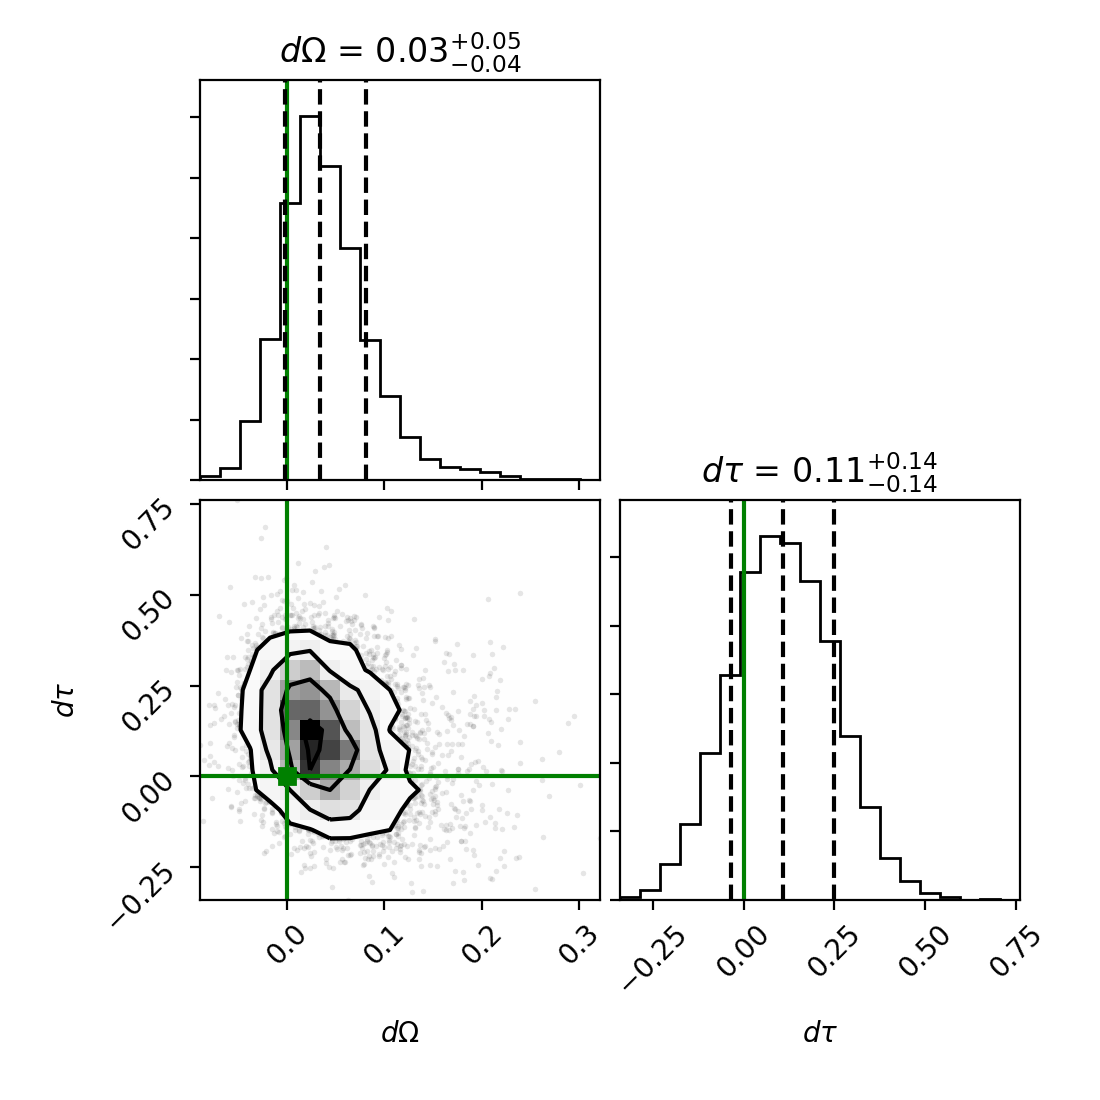

<IPython.core.display.Javascript object>


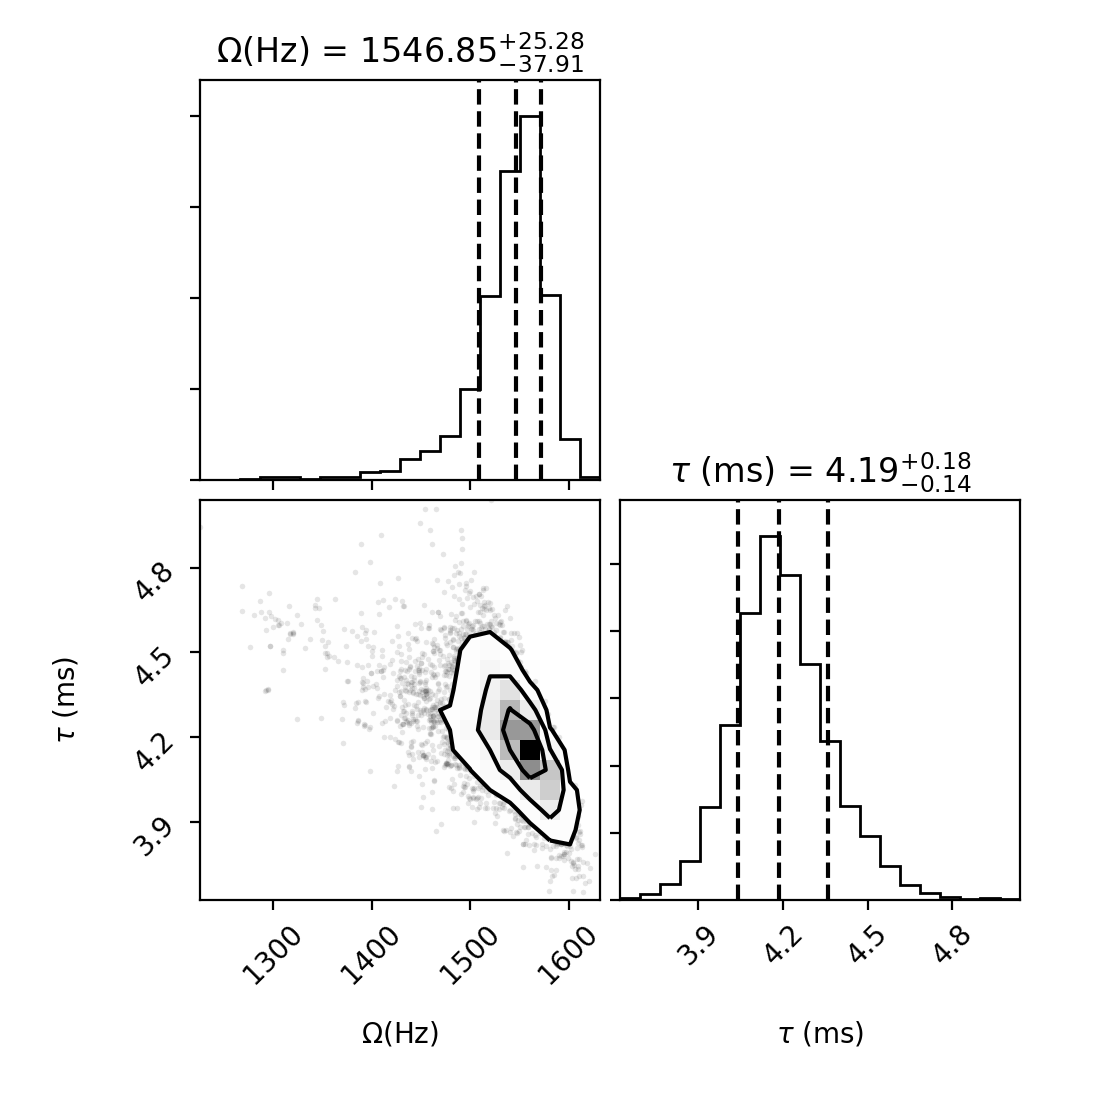

<IPython.core.display.Javascript object>


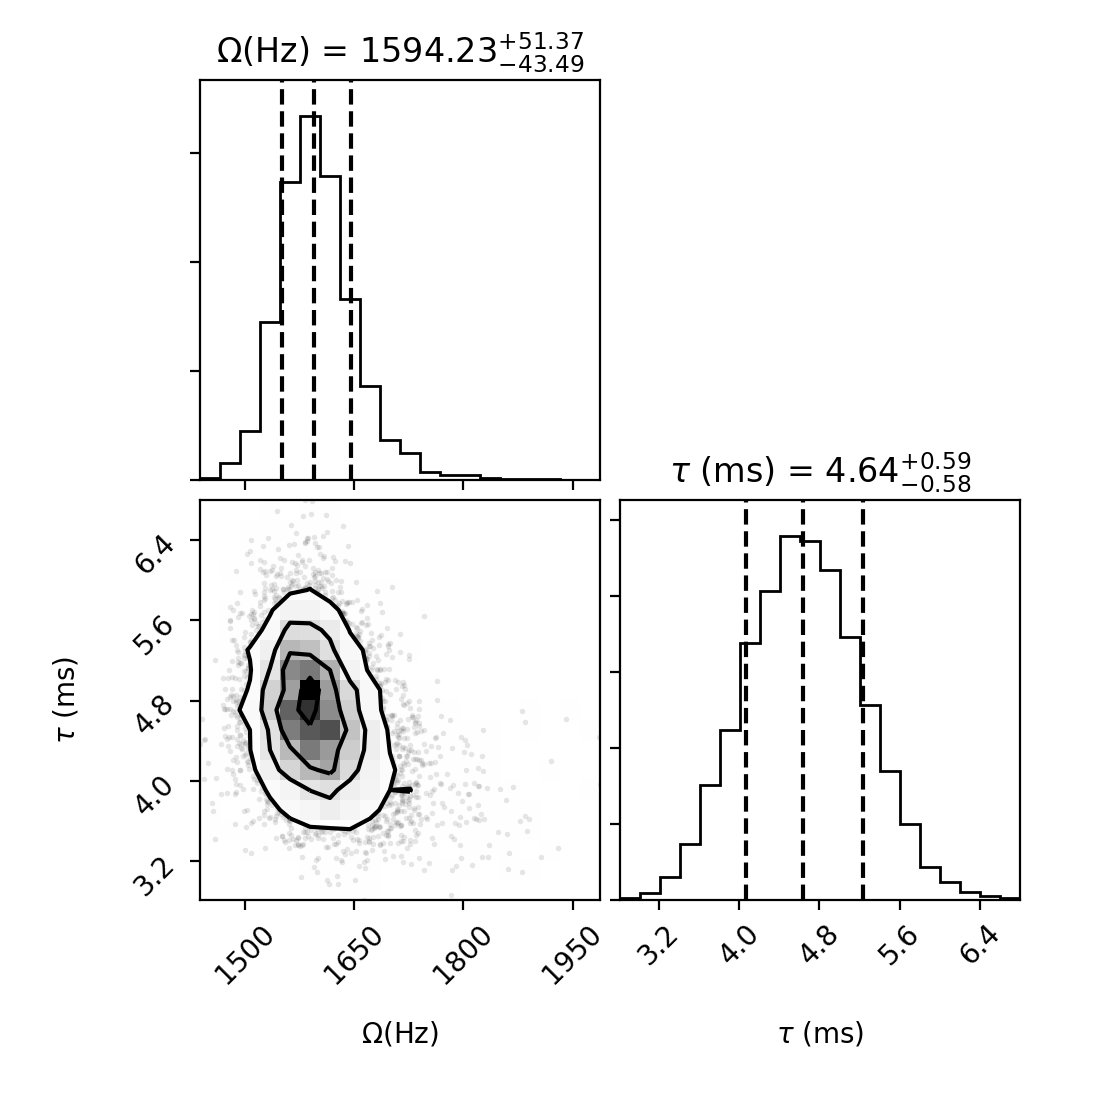

<IPython.core.display.Javascript object>


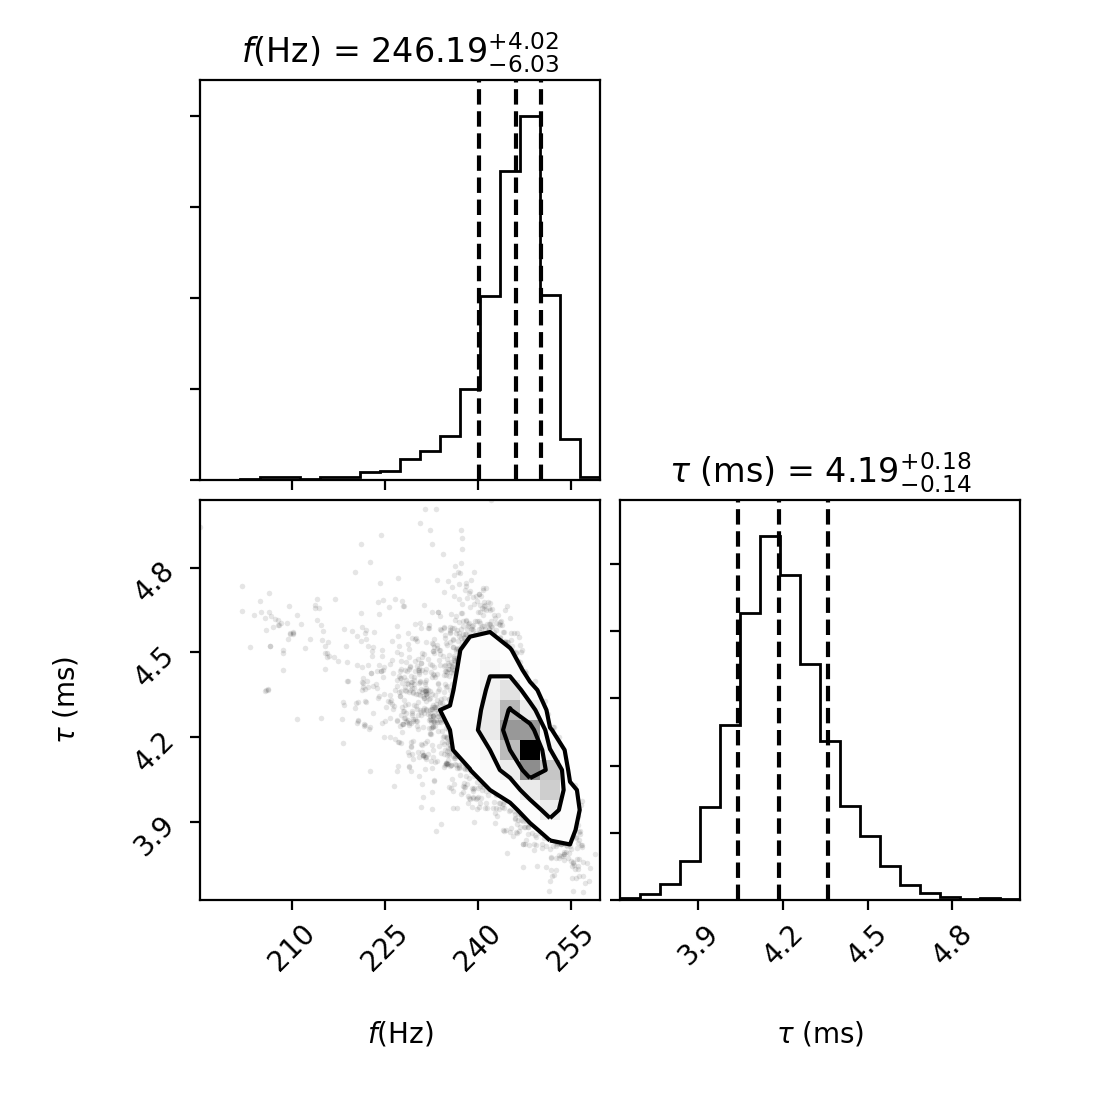

<IPython.core.display.Javascript object>


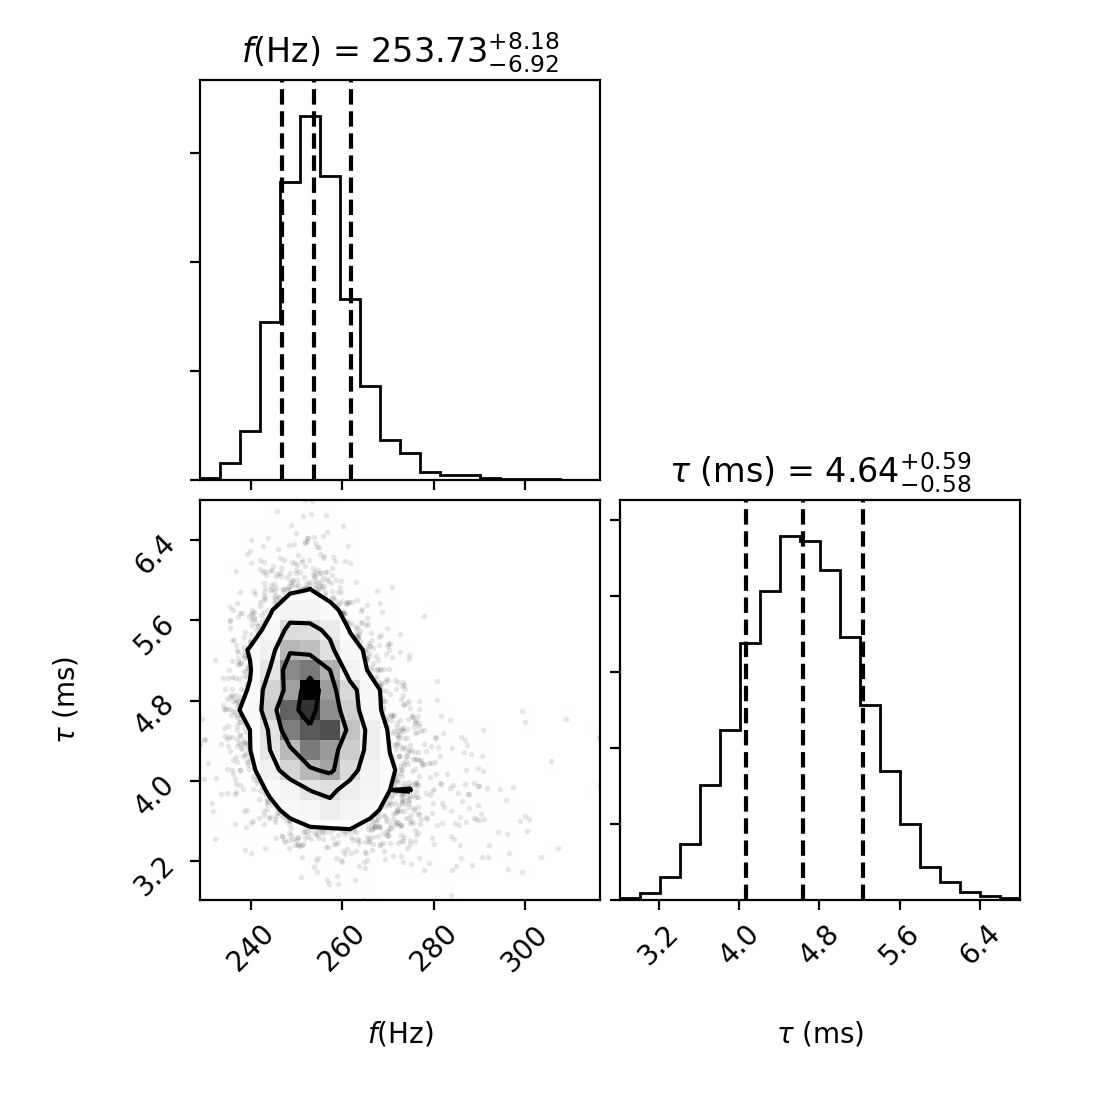

In [8]:
samples_domega_dtau = np.vstack((domega, dtau)).T
corner.corner(samples_domega_dtau, labels=[r"$d\Omega$", r"$d\tau$"], quantiles=(0.16, 0.5, 0.84), truths=[0,0], truth_color='g', show_titles=True, title_kwargs={"fontsize": 12})
#plt.savefig(post_loc + '/%s/qnmtest_frac_params_corner.png'%outdir)

samples_omega_tau_GR = np.vstack((omega_GR, tau_GR*1000.)).T
corner.corner(samples_omega_tau_GR, labels=[r"$\Omega$(Hz)", r"$\tau$ (ms)"], quantiles=(0.16, 0.5, 0.84), show_titles=True, title_kwargs={"fontsize": 12})
#plt.savefig(post_loc + '/%s/qnmtest_abs_params_omega_tau_GR_corner.png'%outdir)

samples_omega_tau_modGR = np.vstack((omega_modGR, tau_modGR*1000.)).T
corner.corner(samples_omega_tau_modGR, labels=[r"$\Omega$(Hz)", r"$\tau$ (ms)"], quantiles=(0.16, 0.5, 0.84), show_titles=True, title_kwargs={"fontsize": 12})
#plt.savefig(post_loc + '/%s/qnmtest_abs_params_omega_tau_modGR_corner.png'%outdir)

samples_freq_tau_GR = np.vstack((freq_GR, tau_GR*1000.)).T
corner.corner(samples_freq_tau_GR, labels=[r"$f$(Hz)", r"$\tau$ (ms)"], quantiles=(0.16, 0.5, 0.84), show_titles=True, title_kwargs={"fontsize": 12})
#plt.savefig(post_loc + '/%s/qnmtest_abs_params_f_tau_GR_corner.png'%outdir)

samples_freq_tau_modGR = np.vstack((freq_modGR, tau_modGR*1000.)).T
corner.corner(samples_freq_tau_modGR, labels=[r"$f$(Hz)", r"$\tau$ (ms)"], quantiles=(0.16, 0.5, 0.84), show_titles=True, title_kwargs={"fontsize": 12})
#plt.savefig(post_loc + '/%s/qnmtest_abs_params_f_tau_modGR_corner.png'%outdir)

plt.show()